In [1]:
import pints
import pints.toy as toy

import emupints
import emupints.plot as emuplt
import emupints.utils as emutils
import emupints.metrics as emumet

from emupints.models import create_small_model, create_average_model, create_large_model

from sklearn.preprocessing import StandardScaler, MinMaxScaler

import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
from tensorflow import keras


import string

# Problem parameters

In [2]:
# Load problem from predefined ones
model = emupints.Problems.FitzhughNagumoModelDiscontinious
problem = emupints.Problems.load_problem(model)

problem['values'][:5]

array([[-1.11311925,  1.15372691],
       [-0.72664515,  1.26351606],
       [-0.9124119 ,  0.79562709],
       [-0.53803925,  0.90528364],
       [-0.28362228,  1.09258919]])

In [3]:
# take required variables for visualisation
n_parameters = problem['n_parameters']
log_likelihood = problem['log_likelihood']
log_prior = problem['log_prior']
log_posterior = problem['log_posterior']
real_parameters = problem['parameters']
pints_problem = problem['problem']
bounds = problem['bounds']
index_to_param_name = problem['param_names']

# Create dataset for training

In [4]:
# training size
training_size = 4000

train_data = log_prior.sample(training_size)
train_target = np.apply_along_axis(log_likelihood, 1, train_data)

# Create NN

In [5]:
EPOCHS = 50
BATCH = 32
validation_split=0.2

In [6]:
# how to scale data
# for input use standardisation, same as GPs
# for output scale linearly in range (-1, 1)
input_scaler = StandardScaler()
output_scaler = MinMaxScaler(feature_range=(-1, 1))

In [7]:
emu = emupints.NNEmulator(log_likelihood, 
                          train_data,
                          train_target,
                          model_size='large',
                          input_scaler=input_scaler, 
                          output_scaler=output_scaler)

In [8]:
# print summary of the model
emu.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                256       
_________________________________________________________________
dense_2 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_3 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_4 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_5 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 65        
Total params: 82,817
Trainable params: 82,817
Non-trainable params: 0
_________________________________________________________________


In [9]:
# store best
mc_callback = keras.callbacks.ModelCheckpoint("models/model_{epoch:02d}.h5", save_weights_only=True)

In [10]:
# store the results during training
val_umae = []

# Callback to calculate unormalized mae
class UnormalizedMAE(keras.callbacks.Callback):

    def on_epoch_end(self, batch, logs={}):
        X_val, y_val = self.validation_data[0], self.validation_data[1]
        
        y_val_predict = np.asarray(self.model.predict(X_val))

        # unormalize predictions
        y_val = output_scaler.inverse_transform(y_val)
        y_val_predict = output_scaler.inverse_transform(y_val_predict)

        # calculate mae
        mae_val = np.mean(np.abs(y_val - y_val_predict))

        # store results
        val_umae.append(mae_val)

        return

In [11]:
#optimizer = tf.train.RMSPropOptimizer(learning_rate)
emu.set_parameters(
    loss='mse',
    optimizer='adam',
    metrics=['mae'] # mean absolute error
)

In [12]:
history = emu.fit(epochs=EPOCHS,
                  batch_size=BATCH,
                  validation_split=validation_split,
#                  callbacks=[UnormalizedMAE(), mc_callback]
                 )

Train on 3200 samples, validate on 800 samples
Epoch 1/50
3200/3200 [==============================] - 1s 213us/step - loss: 0.0552 - mean_absolute_error: 0.1609 - val_loss: 0.0195 - val_mean_absolute_error: 0.0948
Epoch 2/50
3200/3200 [==============================] - 0s 74us/step - loss: 0.0170 - mean_absolute_error: 0.0892 - val_loss: 0.0106 - val_mean_absolute_error: 0.0748
Epoch 3/50
3200/3200 [==============================] - 0s 89us/step - loss: 0.0086 - mean_absolute_error: 0.0590 - val_loss: 0.0059 - val_mean_absolute_error: 0.0447
Epoch 4/50
3200/3200 [==============================] - 0s 98us/step - loss: 0.0055 - mean_absolute_error: 0.0432 - val_loss: 0.0046 - val_mean_absolute_error: 0.0421
Epoch 5/50
3200/3200 [==============================] - 0s 80us/step - loss: 0.0053 - mean_absolute_error: 0.0435 - val_loss: 0.0061 - val_mean_absolute_error: 0.0521
Epoch 6/50
3200/3200 [==============================] - 0s 66us/step - loss: 0.0042 - mean_absolute_error: 0.0377 - v

3200/3200 [==============================] - 0s 64us/step - loss: 0.0021 - mean_absolute_error: 0.0228 - val_loss: 0.0011 - val_mean_absolute_error: 0.0172
Epoch 50/50
3200/3200 [==============================] - 0s 62us/step - loss: 0.0016 - mean_absolute_error: 0.0192 - val_loss: 0.0015 - val_mean_absolute_error: 0.0212


In [13]:
#best_model_idx = np.argmin(val_umae)
#emu._model.load_weights("models/model_{}.h5".format(best_model_idx))

In [14]:
emu(real_parameters)

array([[317.9432]], dtype=float32)

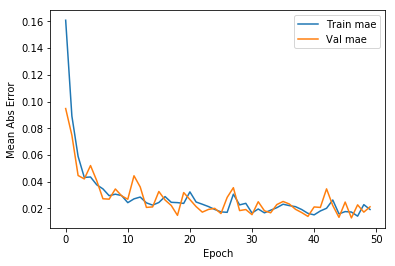

In [15]:
plt.figure()
plt.xlabel('Epoch')
plt.ylabel('Mean Abs Error')
plt.plot(history.epoch, np.array(history.history['mean_absolute_error']),
       label='Train mae')
plt.plot(history.epoch, np.array(history.history['val_mean_absolute_error']),
       label = 'Val mae')
plt.legend()

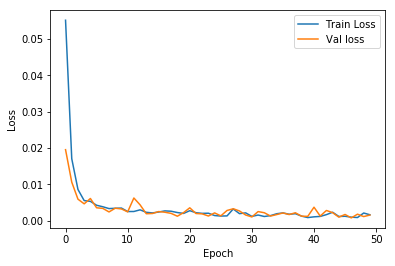

In [16]:
plt.figure()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(history.epoch, np.array(history.history['loss']),
       label='Train Loss')
plt.plot(history.epoch, np.array(history.history['val_loss']),
       label = 'Val loss')
plt.legend()

ValueError: x and y must have same first dimension, but have shapes (50,) and (0,)

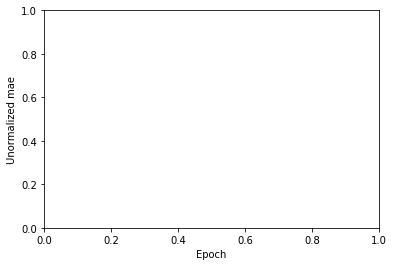

In [17]:
plt.figure()
plt.xlabel('Epoch')
plt.ylabel('Unormalized mae')
plt.plot(history.epoch, val_umae)

In [ ]:
val_umae[-1]

# Plotting model

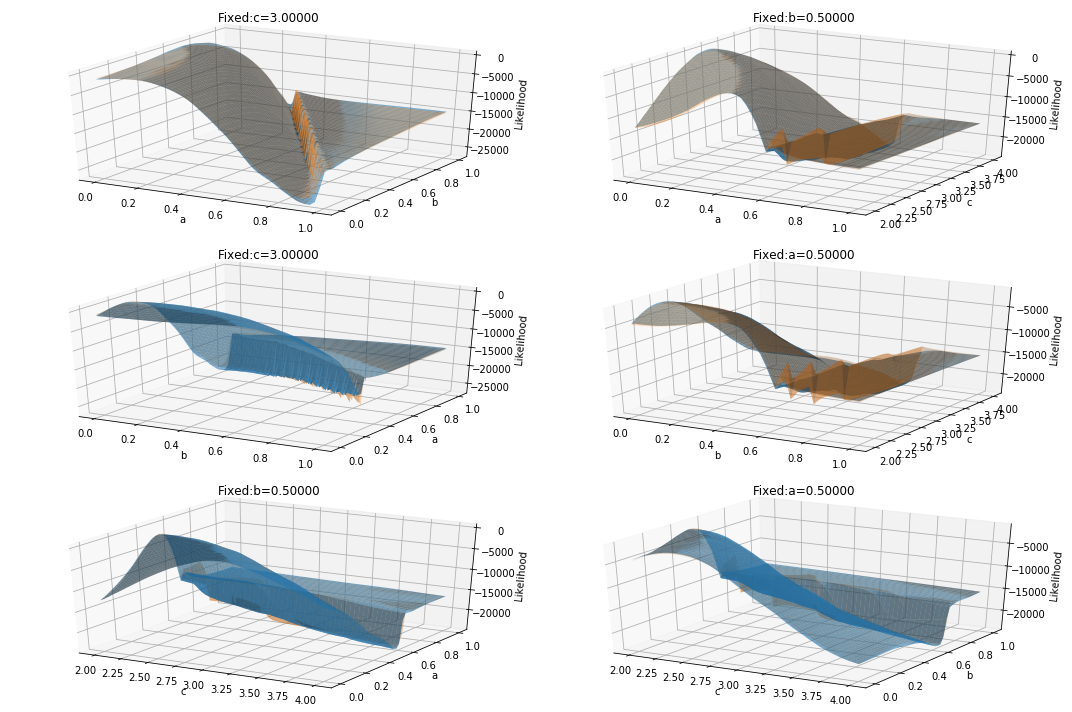

In [18]:
if n_parameters >=3:
    fixed_parameters = emutils.fix_parameters(bounds)
    
    fig, ax = emuplt.plot_fixed_param_grid(
        emu,
        fixed_parameters,
        bounds,
        shape = (n_parameters, n_parameters - 1),
        contour = False,
        index_to_param_name=index_to_param_name,
        additional_log_likelihoods = [log_likelihood]
    )

    plt.show(fig)
    
# for row i we have parameter i fixed and some other parameter j, depending on the column, j != i

In [19]:
print(bounds.lower())
print(bounds.upper())

[0. 0. 2.]
[1. 1. 4.]


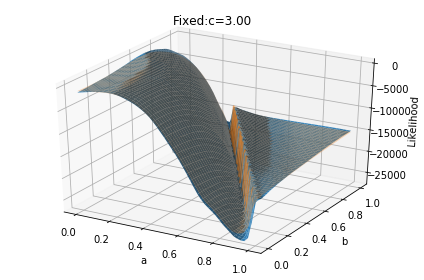

In [20]:
fig, ax = emuplt.plot_surface_fixed_param(
    emu,
    bounds,
    fixed=[(2, 3)],
    index_to_param_name=index_to_param_name,
    contour=False,
    precision=2,
    additional_log_likelihoods=[log_likelihood]
)

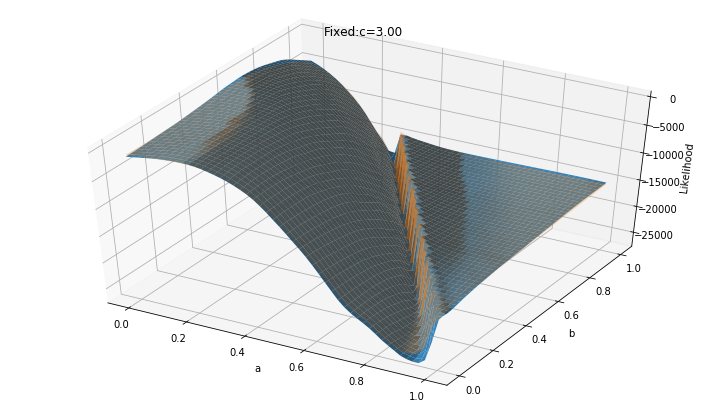

In [22]:
ax.view_init(45, 30 + 90 * 3)
fig.set_size_inches(10.5, 6)
fig

# Timing single prediction

In [ ]:
emu_time = %timeit -o emu(real_parameters)
emu_time.average

In [ ]:
%%timeit
log_likelihood(real_parameters)

In [ ]:
test_X = bounds.sample(500)
test_y = np.apply_along_axis(log_likelihood, 1, test_X)

pred_y = np.apply_along_axis(emu, 1, test_X)

emumet.mae(test_y, pred_y)

# Comparing MCMC run times

In [ ]:
# for Logistic and Lotka-Voltera use default
mcmc_method = None
# mcmc_method = pints.PopulationMCMC
# mcmc_method = pints.AdaptiveCovarianceMCMC
# mcmc_method = pints.DifferentialEvolutionMCMC


# MCMC parameters
num_chains = 3
max_iters = 10000

In [ ]:
# Create a posterior log-likelihood (log(likelihood * prior))
emu_posterior = pints.LogPosterior(emu, log_prior)
real_posterior = pints.LogPosterior(log_likelihood, log_prior)

In [ ]:
# CMA-es
score = pints.SumOfSquaresError(pints_problem)
x0 = bounds.sample(1)[0]

found_parameters, found_value = pints.optimise(
    score,
    x0,
    None,
    bounds,
    method=pints.CMAES
)

In [ ]:
print(found_value)
print(found_parameters)

In [ ]:
xs = [
    found_parameters,
    found_parameters * 1.01,
    found_parameters * 0.99
]
xs

In [ ]:
%%time
emu_mcmc = pints.MCMCSampling(emu_posterior,
                              num_chains,
                              xs,
                              method = mcmc_method,
                             )
emu_mcmc.set_log_to_screen(False)
print('Running...')
emu_chains = emu_mcmc.run()
print('Done!')

In [ ]:
%%time
real_mcmc = pints.MCMCSampling(real_posterior, 
                               num_chains, 
                               xs, 
                               method = mcmc_method,
                               )
real_mcmc.set_max_iterations(max_iters)
real_mcmc.set_log_to_screen(False)
# Run!
print('Running...')
real_chains = real_mcmc.run()
print('Done!')

In [ ]:
import pints.plot
pints.plot.trace(emu_chains)
plt.show()

In [ ]:
pints.plot.trace(real_chains)
plt.show()

In [ ]:
chain = real_chains[0]

emu_prediction = np.apply_along_axis(emu, 1, chain).flatten()
real_prediction = np.apply_along_axis(real_log_likelihood, 1, chain).flatten()

diffs = np.abs(real_prediction - emu_prediction)

In [ ]:
iters = range(len(chain))
plt.figure(figsize=(10, 5))
plt.xlabel("Number of iterations")
plt.ylabel("Log Likelihood")
plt.plot(iters, emu_prediction, color="Red", label='emu')
plt.plot(iters, real_prediction, color="Blue", label='model')
plt.title("Log likelihood along the first chain of MCMC")
plt.legend()
plt.show()

In [ ]:
iters = np.linspace(0, 10000, len(chain))
plt.figure(figsize=(10, 5))
plt.xlabel("Number of iterations")
plt.ylabel("Likelihood difference")
plt.plot(iters, diffs, color = "Black")
plt.show()